# Práctica 2: Planificación de trayectorias
*Práctica 2. Robótica Industrial*

*Alumno: José Antonio Ruiz Millán*

*Curso 2018-2019*

En la práctica 1 realizamos la estimación de las variables de articulación para un robot de tipo RR utilizando el problema cinemático directo y el problema cinemático inverso. Gracias a ello, pudimos simular el movimiento de un robot a lo largo de una trayectoria rectilínea con velocidad constante, y observar las diferentes indeterminaciones que existían. 

En el mundo real, las trayectorias son más complejas que una línea a velocidad constante. Normalmente se requiere tener en cuenta que comenzamos a velocidad 0 y debemos acabar a la misma velocidad 0, y que la trayectoria no va a ser totalmente recta, puesto que muchas veces tenemos que sortear obstáculos. Para ello podemos usar una trayectoria de tipo 4-3-4. 

En esta práctica realizaremos un planificador de trayectorias de tipo 4-3-4, en las que las velocidades y aceleraciones inicial y final son nulas. Hemos estudiado este tipo de trayectorias en teoría, pero recordaremos que constan de tres fases y que interpolan los puntos de inicio, despegue, asentamiento y fin, que nombramos como $\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$. 

Para ello: 
1. Usaremos las funciones `pcd` y `pci` de la práctica anterior, para poder calcular los parámetros del robot.
2. Definiremos la función `planif`, que tomará como entrada estos puntos, el tiempo de duración de cada uno de los trayectos y el periodo de muestreo (para la representación de la trayectoria). Esta función nos devolverá un array con los coeficientes de las ecuaciones de cada una de las trayectorias. 
3. Evaluaremos $\theta_1(t)$ y $\theta_2(t)$ en cada instante usando dichos coeficientes, y mostraremos el robot utilizando la función `robot`y las animaciones que usamos en la práctica anterior. 
4. Mostraremos también gráficas con el progreso de las variables $\theta_i$, la velocidad y la aceleración del robot en cada instante de tiempo. 

En primer lugar, definiremos las posiciones de los puntos de inicio, despegue, asentamiento y fin ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$).

In [1]:
import numpy as np
from numpy.linalg import inv

# Datos de inicio
pini = np.array([1, 0])        # Punto de inicio
pdes = np.array([1, 0.1])      # Punto de despegue
pase = np.array([1.5, 0.1])    # Punto de asentamiento
pfin = np.array([1.5, 0])      # Punto de fin
t1, t2, tn = 1,1,1             # Tiempo de cada segmento de la trayectoria
L1, L2 = 1,1                   # Longitud de los brazos del robot
T = 0.01                       # Periodo de muestreo (para la representación)

### Trayectoria 4-3-4
Como hemos visto en el tema 4, las trayectorias del tipo 4-3-4 siguen unas ecuaciones predefinidas. Para empezar, asumimos que: 
- En el punto de inicio, la aceleración y velocidad son nulas.
- En el punto final la velocidad y aceleración son nulas. 
- En los puntos intermedios debe haber continuidad en posición, velocidad y aceleración. 

A lo largo de la práctica utilizaremos el tiempo normalizado: 

$$ t = \frac{\tau-\tau_{i-1}}{\tau_{i}-\tau_{i-1}} = \frac{\tau-\tau_{i-1}}{t_i} $$

donde $\tau$ es el tiempo real en segundos, $\tau_i$ es el tiempo real al final del $i$-esimo intervalo y $t_i$ es el tiempo total requerido en dicho intervalo. 


Para hacer el desplazamiento con un solo segmento, necesitaríamos un polinomio de grado 8, difícil de resolver y que puede conducir a movimientos extraños y bruscos. Para evitarlo, dividimos la trayectoria en tres segmentos ($h_1$, $h_2$ y $h_n$) con polinomios de grado 4, 3 y 4. Los polinomios que definen el movimiento en cada segmento son:

$$ h_1(t) = a_{14}t^4 + a_{13}t^3 + a_{12}t^2 + a_{11}t + a_{10} $$
$$ h_2(t) = a_{23}t^3 + a_{22}t^2 + a_{21}t + a_{20} $$
$$ h_n(t) = a_{n4}t^4 + a_{n3}t^3 + a_{n2}t^2 + a_{n1}t + a_{n0} $$

Para determinar el movimiento debemos calcular el valor de los 14 coeficientes $a_{ij}$ definidos en los polinomios anteriores. Como hemos visto en clase de teoría, 7 de ellos se pueden calcular directamente a partir de alguna de las restricciones que hemos asumido (velocidad y aceleración iniciales nulas, etc.). Los 7 restantes se pueden calcular a partir de un sistema de 7 ecuaciones con 7 incognitas (véanse las diapositivas 34 y 35 del tema 4) que se puede resolver matricialmente:

$$ \mathbf{x} = \mathbf{C}^{-1}\mathbf{y}$$

siendo:

$$ C = \begin{pmatrix}
1 & 1 & 0 & 0 & 0 & 0 & 0 \\
\frac{3}{t_1} & \frac{4}{t_1} & -\frac{1}{t_2} & 0 & 0 & 0 & 0 \\
\frac{6}{t_1^2} & \frac{12}{t_1^2} & 0 & -\frac{2}{t_2^2} & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 1 & 0 & 0 \\
0 & 0 & \frac{1}{t_2} & \frac{2}{t_2} & \frac{3}{t_2} & -\frac{3}{t_n} & \frac{4}{t_n} \\
0 & 0 & 0 & \frac{2}{t_2^2} & \frac{6}{t_2^2} & \frac{6}{t_n^2} & -\frac{12}{t_n^2} \\
0 & 0 & 0 & 0 & 0 & 1 & -1 
\end{pmatrix}  $$

$$ \mathbf{y} = (\delta_1 - \frac{a_0t_1^2}{2}-v_0t_1, -a_0t1-v_0, -a_0, \delta_2, -a_ft_n + v_f, a_f, \delta_n + \frac{a_ft_n^2}{2}-v_ft_n)$$

por lo que $\mathbf{x}$ tendría la siguiente forma:

$$ \mathbf{x} = (a_{13}, a_{14}, a_{21}, a_{22}, a_{23}, a_{n3}, a_{n4})$$


En la definición de $\mathbf{y}$, los valores $a$ y $v$ representan la aceleración y la velocidad en los puntos inicial y final (no deben confundirse con los coeficientes $a_{ij}$), mientras que $\delta_i$ se define como la diferencia entre $h_i$ al principio y al final del iésimo segmento.


En resumen: 
1. Para obtener los valores de $\theta_1$ y $\theta_2$ tenemos que evaluar los polinomios $h_1$, $h_2$ y $h_n$ (definimos los tres polinomios para **cada** articulación) en el tiempo. 
2. Para calcular $h_1$, $h_2$ y $h_n$, debemos obtener todos los coeficientes $a_{ij}$. 
3. Para calcular los coeficientes $a_{ij}$ necesistamos conocer los valores de $\theta_i$, $a$ (aceleración) y $v$ (velocidad) al principio y al final de cada segmento de la trayectoria.
4. Para calcular los $\theta_i$ en los puntos de inicio, despegue, asentamiento y fin (principio y fin de cada segmento de la trayectoria) haremos uso del `pci` de la práctica anterior. 


In [2]:
# En primer lugar debemos definir la función para resolver el PCI. 
# Podemos copiar la de la práctica anterior.  

def pci(L1,L2,x,y):
    # Devuelve un array con los valores de th1 y th2 para las posiciones (x,y). 
    
    th2 = np.arccos((x*x+y*y-L1*L1-L2*L2)/(2*L1*L2))
    th2_n = -th2
    th1 = np.arctan2((y*(L1+L2*np.cos(th2))-x*L2*np.sin(th2)),(x*(L1+L2*np.cos(th2))+y*L2*np.sin(th2)))
    th1_n = np.arctan2((y*(L1+L2*np.cos(th2_n))-x*L2*np.sin(th2_n)),(x*(L1+L2*np.cos(th2_n))+y*L2*np.sin(th2_n)))
    
    return np.array([th1_n,th2_n]) if th1_n < th1 else np.array([th1,th2])

    
# A continuación, haciendo uso de la función pci, calculamos
# thini, thdes, thase y thfin como arrays de 2 elementos con 
# los ángulos theta1 y theta2 en pini, pdes, pase y pfin
    
thini = pci(L1,L2,pini[0],pini[1])
thdes = pci(L1,L2,pdes[0],pdes[1])
thase = pci(L1,L2,pase[0],pase[1])
thfin = pci(L1,L2,pfin[0],pfin[1])

    

### Cálculo de la trayectoria

Para calcular los coeficientes $a_{ij}$ que definen las ecuaciones de la trayectoria vamos a usar una función, `planif`, que reciba como entrada el valor $\theta_i$ en cada punto de la trayectoria ($\mathbf{p}_{ini}$, $\mathbf{p}_{des}$, $\mathbf{p}_{ase}$ y $\mathbf{p}_{fin}$), y devuelva como salida los coeficientes  $a_{ij}$. Es recomendable devolver los coeficientes como un array 2D, donde cada fila contiene los coeficientes de una ecuación (3 filas), y los coeficientes están ordenados de menor exponente a mayor (5 columnas).


Dado que nuestro robot tiene 2 articulaciones, habrá que llamar 2 veces a `planif`, una con los $\theta_i$ de cada articulación. 

In [3]:
# Definimos la función planif. 

def planif(thini, thdes, thase, thfin, t1, t2, tn):
    #Como podemos ver en el temario, los coeficientes
    #a10,a11,a12,a20,an0,an1,an2
    #se obtienen de forma directa, sin embargo el resto no.
    
    ##################PARAMETROS DIRECTOS######################
    
    #Primer segmento (inicio)
    O0 = thini
    v0 = 0
    a0 = 0
    
    a10 = O0
    a11 = v0 * t1
    a12 = (a0 * t1**2)/2
    
    #Segundo segmento (inicio)
    O1 = thdes
    
    a20 = O1
    
    #Tercer segmento (fin)
    O2 = thase
    Of = thfin
    vf = 0
    af = 0
    
    an0 = Of
    an1 = vf * tn
    an2 = (af * tn**2)/2
    
    ###########################################################
    
    d1 = O1 - O0
    d2 = O2 - O1
    dn = Of - O2
    
    y = np.array([d1-(a0*t1**2)/2-v0*t1,
                  -a0*t1-v0,
                  -a0,
                  d2,
                  -af*tn+vf,
                  af,
                  dn+(af*tn**2)/2-vf*tn])
                 
    C = np.array([
        [1,              1,     0,        0,       0,       0,         0],
        [3/t1,        4/t1, -1/t2,        0,       0,       0,         0],
        [6/t1**2, 12/t1**2,     0, -2/t2**2,       0,       0,         0],
        [0,              0,     1,        1,       1,       0,         0],
        [0,              0,  1/t2,     2/t2,    3/t2,   -3/tn,      4/tn],
        [0,              0,     0,  2/t2**2, 6/t2**2, 6/tn**2, -12/tn**2],
        [0,              0,     0,        0,       0,       1,        -1]
    ])
    
    
    Ci = inv(C)
    
    x = Ci.dot(y)
    
    res = np.array([
        [a10,  a11,  a12, x[0], x[1]],
        [a20, x[2], x[3], x[4],    0],
        [an0,  an1,  an2, x[5], x[6]]
    ])
    
    return res
    
# Y haciendo uso de ella calculamos las ecuaciones para cada segmento de la 
# trayectoria y para cada articulación. 

coef1 = planif(thini[0], thdes[0], thase[0], thfin[0], t1, t2, tn)
coef2 = planif(thini[1], thdes[1], thase[1], thfin[1], t1, t2, tn)

print("Coeficientes: ")
print(coef1)
print(coef2)

Coeficientes: 
[[-1.04719755  0.          0.          0.11924132 -0.0166907 ]
 [-0.94464693  0.29096117  0.25757977 -0.25753953  0.        ]
 [-0.72273425  0.          0.         -0.30985708 -0.24076834]]
[[ 2.0943951   0.          0.          0.30951135 -0.31527529]
 [ 2.08863116 -0.33256712 -0.9631177   0.64748102  0.        ]
 [ 1.4454685   0.          0.          0.33652408  0.33148293]]


A continuación vamos a simular el desplazamiento. Para ello necesitamos muestrear el tiempo con periodo de muestreo $T$ y, en cada instante de tiempo, obtener el valor de las variables de articulación ($\theta_1$ y $\theta_2$). Esto debemos hacerlo independientemente para cada segmento de la trayectoria, usando las ecuaciones que hemos calculado anteriormente.

Recordad que estamos utilizando el tiempo normalizado: 

$$ t = \frac{\tau-\tau_{i-1}}{\tau_i -\tau_{i-1}}$$

con $\tau$ el tiempo en segundos, $\tau_i$ el tiempo al final del $i$-ésimo segmento de la trayectoria y $\tau_i-\tau_{i-1}$ el tiempo que toma en el iésimo segmento de la trayectoria. Asimismo, recuerda que en el último segmento realizamos un último cambio de variable $\hat{t}=t-1$, con lo que el rango de tiempo normalizado pasa de (0,1) a (-1,0). 

In [4]:
# Para cada articulación, obtenemos el valor del ángulo en cada segmento de
# la trayectoria y concatenamos los ángulos de los tres segmentos para obtener
# un solo vector de ángulos por articulación.

from numpy.polynomial.polynomial import polyval

#Los ponemos en el orden adecuado para poder ejecutar polyval
a1_1 = coef1[0,::-1]
a2_1 = coef1[1,::-1]
an_1 = coef1[2,::-1]

a1_2 = coef2[0,::-1]
a2_2 = coef2[1,::-1]
an_2 = coef2[2,::-1]

eval1 = np.polyval(a1_1, np.arange(0,1,T))
eval2 = np.polyval(a2_1, np.arange(0,1,T))
eval3 = np.polyval(an_1, np.arange(0,1,T)-1)

eval4 = np.polyval(a1_2, np.arange(0,1,T))
eval5 = np.polyval(a2_2, np.arange(0,1,T))
eval6 = np.polyval(an_2, np.arange(0,1,T)-1)

ths1 = np.r_[eval1, eval2, eval3]
ths2 = np.r_[eval4, eval5, eval6]

print ("\nEvaluaciones: ")
print (ths1)
print (ths2)


Evaluaciones: 
[-1.04719755 -1.04719743 -1.0471966  -1.04719435 -1.04718996 -1.04718275
 -1.04717201 -1.04715705 -1.04713718 -1.04711172 -1.04707998 -1.04704128
 -1.04699496 -1.04694035 -1.04687676 -1.04680356 -1.04672008 -1.04662566
 -1.04651966 -1.04640143 -1.04627033 -1.04612572 -1.04596697 -1.04579345
 -1.04560453 -1.0453996  -1.04517804 -1.04493923 -1.04468256 -1.04440742
 -1.04411323 -1.04379938 -1.04346527 -1.04311031 -1.04273393 -1.04233554
 -1.04191457 -1.04147043 -1.04100257 -1.0405104  -1.03999339 -1.03945096
 -1.03888256 -1.03828765 -1.03766568 -1.03701611 -1.0363384  -1.03563201
 -1.03489643 -1.03413111 -1.03333555 -1.03250923 -1.03165163 -1.03076224
 -1.02984055 -1.02888608 -1.02789831 -1.02687676 -1.02582094 -1.02473036
 -1.02360454 -1.022443   -1.02124528 -1.0200109  -1.01873939 -1.0174303
 -1.01608316 -1.01469754 -1.01327296 -1.011809   -1.01030521 -1.00876116
 -1.0071764  -1.00555051 -1.00388307 -1.00217366 -1.00042185 -0.99862724
 -0.99678941 -0.99490797 -0.9929825 

## Trazado de la Trayectoria
A continuación vamos a representar el movimiento del robot y los diferentes puntos de la trayectoria. Usaremos `matplotlib.pyplot` para visualización y las herramientas que ya utilizamos en la práctica anterior. Tened en cuenta que vamos a dibujar la trayectoria del efector a partir de los ángulos de cada articulación, esto es, necesitamos resolver el PCD.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML 

# Usando el módulo animation y código similar al de la práctica anterior,
# representamos la trayectoria que sigue el robot (asi como el brazo robótico)
# durante el movimiento

def robot(L1,th1,p, ax):
    x=[0, L1*np.cos(th1), p[0]]
    y=[0, L1*np.sin(th1), p[1]]
    ax.plot(x,y, color='k', linewidth=2)
    ax.axis([-2, 2, -2, 2])
    ax.set_aspect('equal')
    
def init():
    ax.clear() # Limpiamos los ejes actuales
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_xlim(-2,2) # Establece los límites del eje x
    ax.set_ylim(-2,2) # y del eje y
    ax.set_aspect('equal') # Hace que la proporción de ambos ejes sea 1:1
    
def pcd(L1, L2, th1, th2):
    px=L1*np.cos(th1)+L2*np.cos(th1+th2)
    py=L1*np.sin(th1)+L2*np.sin(th1+th2)
    
    pxy = np.vstack((px,py))

    return pxy.T
    
def pintarPCD(i, L1, L2, th1, th2 ,ax):
    init()
    # Resto de código para elegir el punto actual (i), pintar la trayectoria hasta el punto actual y
    # pintar el robot en esa configuración.
    
    p = pcd(L1,L2,th1[:i+1],th2[:i+1])
    
    ax.plot(p[:,0],p[:,1])
    robot(L1,th1[i],p[i],ax)
    


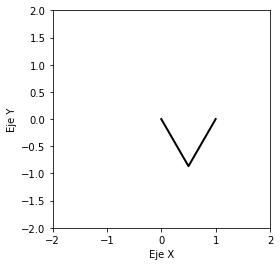

In [6]:
#Pintamos el resultado

fig, ax = plt.subplots()
N = ths1.shape[0]
anim = animation.FuncAnimation(fig, pintarPCD, frames = N, fargs = (L1, L2, ths1, ths2, ax), interval = .1/T) 
# HTML(anim.to_html5_video())
HTML(anim.to_jshtml())

## Visualización de las variables
Ahora mostraremos, en función del tiempo: 
1. Los valores de $\theta_1$ y $\theta_2$
2. Los valores de velocidad $v_1$ y $v_2$
3. Los valores de aceleración $a_1$ y $a_2$

Dado que la velocidad y la acelaración son la primera y la segunda derivada de la trayectoria, podemos utilizar `polyder` para obtener sus coeficientes de los polinomios que definen la velocidad y la aceleración y, una vez obtenidos, `polyval` para evaluar las funciones resultantes.


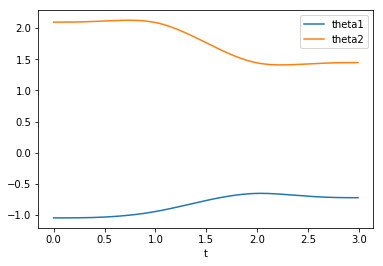

In [7]:
# Obtenemos el vector de muetras de tiempo
t = np.arange(0, t1+t2+tn, T)

# Representamos los ángulos theta1 y theta2 en función del tiempo
plt.plot(t,ths1,label="theta1")
plt.plot(t,ths2,label="theta2")
plt.xlabel("t")
plt.legend()

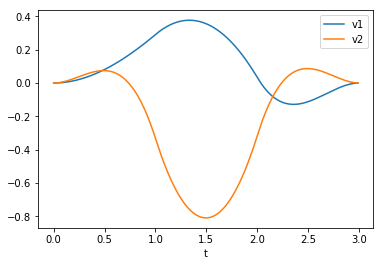

In [8]:
# Calculamos las funciones de la velocidad (derivada de la trayectoria)
from numpy.polynomial.polynomial import polyder

h1_1 = np.polyval(np.polyder(a1_1), np.arange(0,1,T))
h2_1 = np.polyval(np.polyder(a2_1), np.arange(0,1,T))
hn_1 = np.polyval(np.polyder(an_1), np.arange(0,1,T)-1)
v1 = np.r_[h1_1, h2_1, hn_1]

h1_2 = np.polyval(np.polyder(a1_2), np.arange(0,1,T))
h2_2 = np.polyval(np.polyder(a2_2), np.arange(0,1,T))
hn_2 = np.polyval(np.polyder(an_2), np.arange(0,1,T)-1)
v2 = np.r_[h1_2, h2_2, hn_2]

# Representamos la velocidad de cada eslabón en función del tiempo

plt.plot(t, v1, label= "v1")
plt.plot(t, v2, label= "v2")
plt.xlabel("t")
plt.legend()

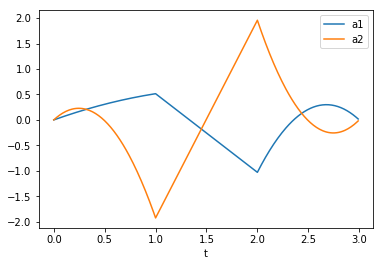

In [9]:
# Calculamos las funciones de la aceleración (derivada de la velocidad)
h1_1 = np.polyval(np.polyder(a1_1, m=2), np.arange(0,1,T))
h2_1 = np.polyval(np.polyder(a2_1, m=2), np.arange(0,1,T))
hn_1 = np.polyval(np.polyder(an_1, m=2), np.arange(0,1,T)-1)
a1 = np.r_[h1_1, h2_1, hn_1]

h1_2 = np.polyval(np.polyder(a1_2, m=2), np.arange(0,1,T))
h2_2 = np.polyval(np.polyder(a2_2, m=2), np.arange(0,1,T))
hn_2 = np.polyval(np.polyder(an_2, m=2), np.arange(0,1,T)-1)
a2 = np.r_[h1_2, h2_2, hn_2]

# Representamos la aceleración de cada eslabón en función del tiempo

plt.plot(t, a1, label= "a1")
plt.plot(t, a2, label= "a2")
plt.xlabel("t")
plt.legend()